In [23]:
from __future__ import division
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
from sklearn import cross_validation, datasets, metrics, linear_model, decomposition, tree, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [214]:
df = pd.read_csv('health_cov.csv')

In [215]:
def data_process(df):
    del df['aa_primarykey']
    df['bld'] = df['bld'].apply(lambda x: -1 if math.isnan(x) else x)
    df['cow'] = df['cow'].apply(lambda x: -1 if math.isnan(x) else x)
    df['fes'] = df['fes'].apply(lambda x: -1 if math.isnan(x) else x)
    df['hht'] = df['hht'].apply(lambda x: -1 if math.isnan(x) else x)
    df['hincp'] = df['hincp'].apply(lambda x: 0 if math.isnan(x) else x)
    df['indp'] = df['indp'].apply(lambda x: -1 if math.isnan(x) else x)
    df['jwtr'] = df['jwtr'].apply(lambda x: -1 if math.isnan(x) else x)
    df['mil'] = df['mil'].apply(lambda x: -1 if math.isnan(x) else x)
    df['msp'] = df['msp'].apply(lambda x: -1 if math.isnan(x) else x)
    df['mv'] = df['mv'].apply(lambda x: -1 if math.isnan(x) else x)
    df['noc'] = df['noc'].apply(lambda x: 0 if math.isnan(x) else x)
    df['pap'] = df['pap'].apply(lambda x: 0 if math.isnan(x) else x)
    df['rwat'] = df['rwat'].apply(lambda x: -1 if math.isnan(x) else x)
    df['sch'] = df['sch'].apply(lambda x: -1 if math.isnan(x) else x)
    df['semp'] = df['semp'].apply(lambda x: 0 if math.isnan(x) else x)
    df['veh'] = df['veh'].apply(lambda x: 0 if math.isnan(x) else x)
    df['wif'] = df['wif'].apply(lambda x: 0 if math.isnan(x) else x)
    df['wkhp'] = df['wkhp'].apply(lambda x: 0 if math.isnan(x) else x)
    unlabeled = df[df['hicov'].apply(lambda x: math.isnan(x))]
    labeled = df[df['hicov'].apply(lambda x: not math.isnan(x))]
    unlabeled['hicov'] = unlabeled['hicov'].replace(np.nan, 0)
    for i in labeled.columns:
        labeled[i] = labeled[i].astype(int)
    for i in unlabeled.columns:
        unlabeled[i] = unlabeled[i].astype(int)
    # Want to predict which DON'T have health insurance.  So first turn 1 (have ins) into 0, then turn 2 (no ins) into 1.
    y = 1-(labeled["hicov"]==1).astype(int)
    del labeled['hicov']
    cat_columns = ['bld', 'cit', 'cow', 'dis', 'fes', 'fs', 'hht', 'indp', 'jwtr', 'mar', 'mil', 'msp', 'mv', 'puma', 
              'rac1p', 'rwat', 'sch', 'sex', 'st', 'type']
    for i in cat_columns:
        labeled[i] = labeled[i].astype('category')
    for i in cat_columns:
        unlabeled[i] = unlabeled[i].astype('category')
    labeled = labeled.reset_index()
    unlabeled = unlabeled.reset_index()
    y = y.reset_index()
    labeled_dummies = pd.get_dummies(labeled, columns=cat_columns)
    unlabeled_dummies = pd.get_dummies(unlabeled, columns=cat_columns)
    del labeled_dummies['index']
    del unlabeled_dummies['index']
    del unlabeled['index']
    del y['index']
    return labeled_dummies, unlabeled_dummies, unlabeled, y

In [216]:
def model_info(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    model.fit(X_train, y_train)
    digit_prec=2
    truthvec = y_test
    try:
        model.predict_proba
        scorevec = model.predict_proba(X_test)[:,1]
        threshvec = np.unique(np.round(scorevec,digit_prec))
        numthresh = len(threshvec)
        tpvec = np.zeros(numthresh)
        fpvec = np.zeros(numthresh)
        fnvec = np.zeros(numthresh)
        for i in range(numthresh):
            thresh = threshvec[i]
            tpvec[i] = sum(truthvec[scorevec>=thresh])
            fpvec[i] = sum(1-truthvec[scorevec>=thresh])
            fnvec[i] = sum(truthvec[scorevec<thresh])
        recallvec = tpvec/(tpvec + fnvec)
        precisionvec = tpvec/(tpvec + fpvec)
        f1vec = 2*precisionvec*recallvec/(precisionvec + recallvec)
        x = zip(threshvec, f1vec)
        rec_x = zip(threshvec, recallvec)
        max_f1 = sorted(x, key=lambda m: m[1], reverse=True)[0]
        #max_recall = sorted(rec_x, key=lambda m: m[1], reverse=True)[0]
        #fpr, tpr, thresholds = roc_curve(y_test, scorevec)
        #plt.plot(fpr, tpr);
        #plt.plot(fpr,fpr, 'r--');
        #plt.xlabel("False Positive Rate (1 - Specificity)");
        #plt.ylabel("True Positive Rate (Sensitivity)");
        #print(score)
        print('Max F1: ', max_f1)

    except:
        scorevec = model.predict(X_test)
        print('F1: ', f1_score(y_test, scorevec))
    score = roc_auc_score(y_test, scorevec)
#     x = zip(threshvec, f1vec)
#     rec_x = zip(threshvec, recallvec)
#     max_f1 = sorted(x, key=lambda m: m[1], reverse=True)[0]
#     #max_recall = sorted(rec_x, key=lambda m: m[1], reverse=True)[0]
#     fpr, tpr, thresholds = roc_curve(y_test, scorevec)
#     plt.plot(fpr, tpr);
#     plt.plot(fpr,fpr, 'r--');
#     plt.xlabel("False Positive Rate (1 - Specificity)");
#     plt.ylabel("True Positive Rate (Sensitivity)");
    print('AUC: ', score)
#     print('Max F1: ', max_f1)
#    print('Max Recall: ', max_recall)
    col_keep = []
    col_reg = []
#     try:
#         model.feature_importances_
#         features = zip(model.feature_importances_, X_train.columns)
#         features.sort(key = lambda t: t[0], reverse=True)
#         for i in range(len(features)):
#             if features[i][0] != 0:
#                 col_keep.append(features[i][1])
#             else:
#                 col_reg.append(features[i][1])
#     except:
#         zipped = sorted(zip(model.coef_[0], X.columns), key= lambda t: abs(t[0]), reverse=True)
#         for i in range(len(zipped)):
#             if zipped[i][0] != 0:
#                 col_keep.append(zipped[i][1])
#             else:
#                 col_reg.append(zipped[i][1])
    return model, col_keep, col_reg

In [217]:
def model_info2(model, X, y):
    g = y['hicov']
    skf = StratifiedKFold(g, 5)
    f1_scores = []
    auc_scores = []
    for train_index, test_index in skf:
        X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
        y_train, y_test = g[train_index], g[test_index]
        model.fit(X_train, y_train)
        digit_prec=2
        truthvec = y_test
        try:
            model.predict_proba
            scorevec = model.predict_proba(X_test)[:,1]
            threshvec = np.unique(np.round(scorevec,digit_prec))
            numthresh = len(threshvec)
            tpvec = np.zeros(numthresh)
            fpvec = np.zeros(numthresh)
            fnvec = np.zeros(numthresh)
            for i in range(numthresh):
                thresh = threshvec[i]
                tpvec[i] = sum(truthvec[scorevec>=thresh])
                fpvec[i] = sum(1-truthvec[scorevec>=thresh])
                fnvec[i] = sum(truthvec[scorevec<thresh])
            recallvec = tpvec/(tpvec + fnvec)
            precisionvec = tpvec/(tpvec + fpvec)
            f1vec = 2*precisionvec*recallvec/(precisionvec + recallvec)
            x = zip(threshvec, f1vec)
            rec_x = zip(threshvec, recallvec)
            max_f1 = sorted(x, key=lambda m: m[1], reverse=True)[0]
            max_f1_thresh = max_f1[0]
            recall_index = [i for i, v in enumerate(rec_x) if v[0] == max_f1_thresh][0]
            recall = rec_x[recall_index][1]
            print('Max F1 is %f which is for threshold %f' %(max_f1[1], max_f1_thresh))
            print('Corresponding recall is %f' %recall)
            f1_scores.append(max_f1[1])
        except:
            scorevec = model.predict(X_test)
            f1_scr = f1_score(y_test, scorevec)
            print('F1: ', f1_scr)
            f1_scores.append(f1_scr)
        auc = roc_auc_score(y_test, scorevec)
        auc_scores.append(auc)
        print('AUC: ', auc)
    mean_f1 = np.mean(f1_scores)
    mean_auc = np.mean(auc_scores)
    print('Mean F1: ', mean_f1)
    print('Mean AUC: ', mean_auc)
    col_keep = []
    col_reg = []
    try:
        model.feature_importances_
        features = zip(model.feature_importances_, X_train.columns)
        features.sort(key = lambda t: t[0], reverse=True)
        for i in range(len(features)):
            if features[i][0] != 0:
                col_keep.append(features[i][1])
                print('Importance: ', features[i])
            else:
                col_reg.append(features[i][1])
    except:
        print('Intercept: ', model.intercept_)
        zipped = sorted(zip(model.coef_[0], X.columns), key= lambda t: abs(t[0]), reverse=True)
        for i in range(len(zipped)):
            if zipped[i][0] != 0:
                col_keep.append(zipped[i][1])
                print('Coefficient: ',zipped[i])
            else:
                col_reg.append(zipped[i][1])
    return model, col_keep, col_reg

In [166]:
def normalize_df(df, num_columns):
    df_norm = df.copy()
    for i in num_columns:
        mean = df[i].mean()
        std = df[i].std()
        df_norm[i] = df_norm[i].apply(lambda x: (x - mean)/std)
    return df_norm

In [218]:
num_columns = ['agep', 'semp', 'hincp', 'np', 'noc', 'pap', 'veh', 'wif', 'wkhp']

In [219]:
labeled_dummies, unlabeled_dummies, unlabeled, y = data_process(df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [220]:
labeled_dummies_norm = normalize_df(labeled_dummies, num_columns)

In [176]:
log_reg, col_keep, col_reg = model_info2(LogisticRegression(penalty='l1', C=0.1), labeled_dummies, y)

Max F1 is 0.484657 which is for threshold 0.200000
Corresponding recall is 0.608530
('AUC: ', 0.8495329476573148)
Max F1 is 0.469451 which is for threshold 0.200000
Corresponding recall is 0.589028
('AUC: ', 0.84093770693627057)
Max F1 is 0.480149 which is for threshold 0.230000
Corresponding recall is 0.550341
('AUC: ', 0.84656437959865516)
Max F1 is 0.481892 which is for threshold 0.250000
Corresponding recall is 0.516886
('AUC: ', 0.84302095020883883)
Max F1 is 0.481357 which is for threshold 0.220000
Corresponding recall is 0.566989
('AUC: ', 0.84504324560423483)
('Mean F1: ', 0.4795012853307381)
('Mean AUC: ', 0.84501984600106295)
('Intercept: ', array([ 0.]))
('Coefficient: ', (-1.9148017087548044, 'mil_1'))
('Coefficient: ', (-1.3723252734447675, 'type_3'))
('Coefficient: ', (-1.3124166695500381, 'st_25'))
('Coefficient: ', (0.97221778407669679, 'cit_5'))
('Coefficient: ', (0.85351048257240203, 'st_2'))
('Coefficient: ', (-0.78605696221276222, 'sch_-1'))
('Coefficient: ', (-0.75

In [221]:
final_model = LogisticRegression(penalty='l1', C=0.1)
final_model.fit(labeled_dummies,y)

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [235]:
labeled_dummies_sm = sm.add_constant(labeled_dummies, prepend=False)

In [236]:
logit = sm.Logit(y, labeled_dummies_sm.drop(col_reg, axis=1))
result = logit.fit()
print result.summary()

         Current function value: 0.266934
         Iterations: 35


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                  hicov   No. Observations:               272762
Model:                          Logit   Df Residuals:                   272517
Method:                           MLE   Df Model:                          244
Date:                Thu, 27 Oct 2016   Pseudo R-squ.:                  0.2546
Time:                        21:01:55   Log-Likelihood:                -72809.
converged:                      False   LL-Null:                       -97674.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
agep          -0.0292      0.001    -41.309      0.000        -0.031    -0.028
hincp      -1.381e-05   2.36e-07    -58.621      0.000     -1.43e-05 -1.33e-05
noc           -0.2434      0.009    -28.304      0.0

In [244]:
coeffs = pd.read_csv('coeffs.csv')

In [245]:
coeffs = coeffs[coeffs['pval'] <= 0.05]

In [246]:
coeffs.sort(columns='pval', inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [249]:
coeffs = coeffs.reset_index()

In [262]:
coeffs.to_csv('data.csv')

In [259]:
coeffs[0:50]

,feature,coef,std_err,z,pval,95Conf,Int
0,agep,-0.0292,0.001,-41.309,0.0,-0.031,-0.028
1,jwtr_,5 -0.9202,0.246,-3.741,0.0,-1.402,-0.438
2,jwtr_,1 -0.2975,0.034,-8.650,0.0,-0.365,-0.230
3,jwtr_,-1 0.3397,0.038,9.055,0.0,0.266,0.413
4,indp_,9290 0.5435,0.080,6.825,0.0,0.387,0.700
5,indp_,9070 0.4982,0.141,3.533,0.0,0.222,0.775
6,indp_,8990 0.6573,0.136,4.832,0.0,0.391,0.924
7,indp_,8770 0.5574,0.075,7.401,0.0,0.410,0.705
8,indp_,8690 0.8034,0.156,5.136,0.0,0.497,1.110
9,indp_,8680 0.3628,0.031,11.622,0.0,0.302,0.424


In [260]:
coeffs[50:100]

,feature,coef,std_err,z,pval,95Conf,Int
50,indp_,7390 -0.4966,1.210000e-01,-4.102,0.000,-0.734000,-0.259000
51,indp_,7380 -0.4837,1.070000e-01,-4.521,0.000,-0.693000,-0.274000
52,indp_,8980 0.4148,8.900000e-02,4.659,0.000,0.240000,0.589000
53,st_55,-0.5069,6.100000e-02,-8.284,0.000,-0.627000,-0.387000
54,indp_,2290 -0.8751,2.470000e-01,-3.542,0.000,-1.359000,-0.391000
55,indp_,280 1.0743,2.770000e-01,3.874,0.000,0.531000,1.618000
56,indp_,270 0.9914,1.990000e-01,4.979,0.000,0.601000,1.382000
57,indp_,170 0.2686,7.000000e-02,3.830,0.000,0.131000,0.406000
58,fs_1,-0.2253,2.000000e-02,-11.135,0.000,-0.265000,-0.186000
59,cow_6,0.3139,7.100000e-02,4.427,0.000,0.175000,0.453000


In [261]:
coeffs.shape

(153, 7)

In [265]:
states = pd.read_csv('data.csv')

In [273]:
states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
state    32 non-null object
coef     32 non-null float64
dtypes: float64(1), object(1)
memory usage: 584.0+ bytes


In [274]:
x = range(len(states['state']))
y = states['coef']

In [287]:
unlabeled.shape

(187849, 30)

<Container object of 32 artists>

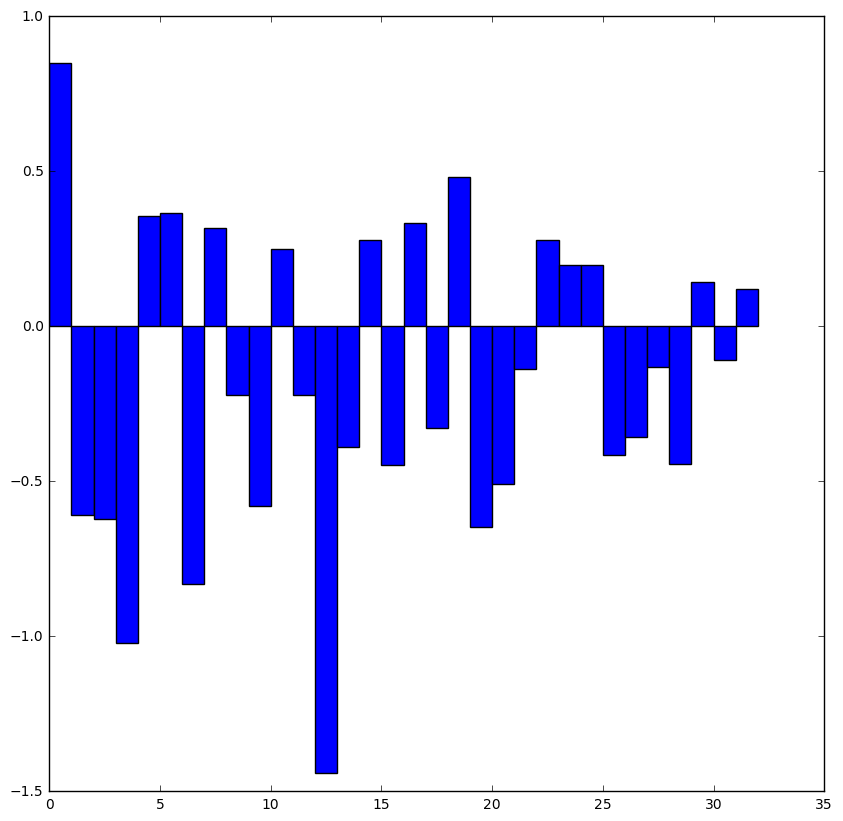

In [282]:
fig = plt.figure(figsize=(10,10))
plt.bar(x, y, width=1,color="blue")

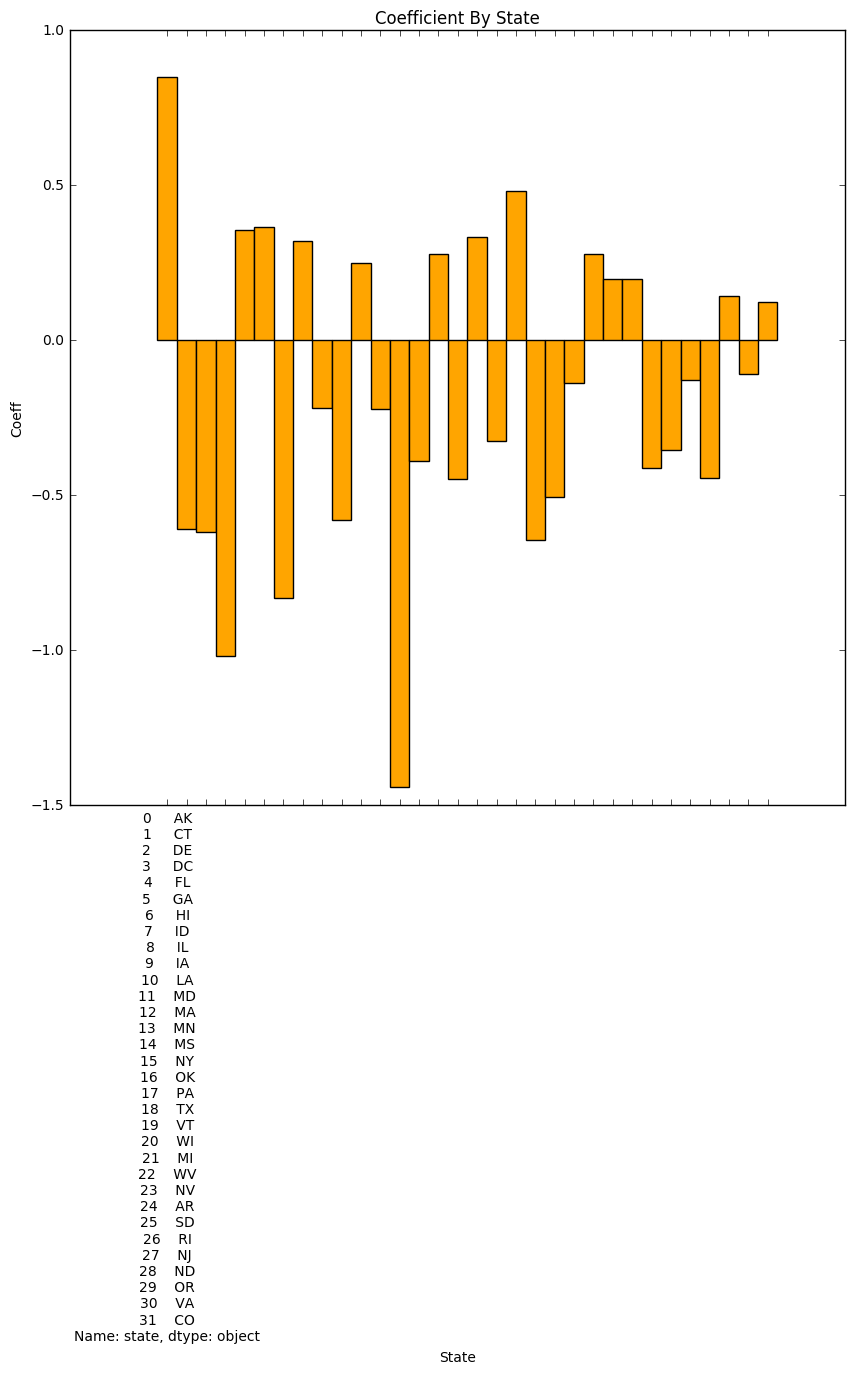

In [292]:
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(1,1,1)
x = range(len(states['state']))
foo = states['coef']
axes.bar(x,foo, align='center', color = 'orange', width=1)
axes.set_ylabel('Coeff')
axes.set_xlabel('State')
axes.set_xticks(x)
axes.set_xticklabels([states['state']])
axes.set_title('Coefficient By State');

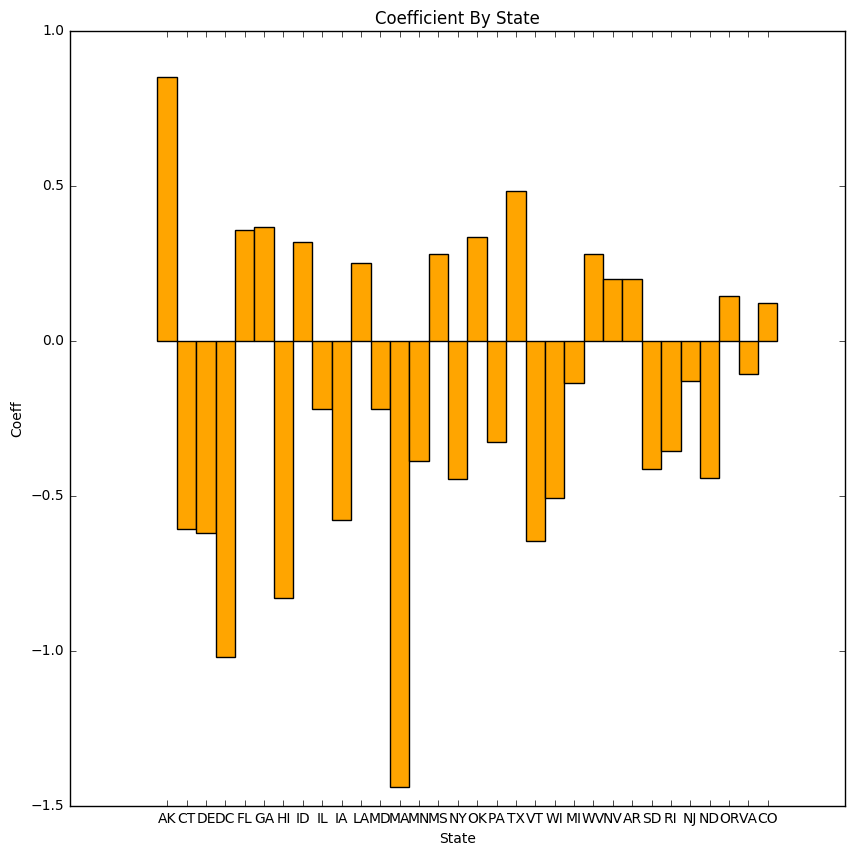

In [298]:
labels = ['AK', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IA', 'LA', 'MD', 'MA', 'MN', 'MS', 'NY', 'OK', 'PA', 'TX', 'VT', 'WI', 'MI', 'WV', 'NV', 'AR', 'SD', 'RI', 'NJ', 'ND', 'OR', 'VA', 'CO'
]
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(1,1,1)
x = range(len(states['state']))
foo = states['coef']
axes.bar(x,foo, align='center', color = 'orange', width=1)
axes.set_ylabel('Coeff')
axes.set_xlabel('State')
axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.set_title('Coefficient By State');

In [ ]:
fig = plt.figure(figsize=(5,5))
axes = fig.add_subplot(1,1,1)
x = [0,1]
foo = states['state']
axes.bar(x,foo, align='center', color = 'orange', width=.2)
axes.set_ylabel('Count')
axes.set_xlabel('Party')
axes.set_xticks(x)
axes.set_xticklabels(['Democrat','Republican'])
axes.set_title('Party count');

In [266]:
states

,state,coef
0,AK,0.8503
1,CT,-0.6078
2,DE,-0.6203
3,DC,-1.0199
4,FL,0.3567
5,GA,0.3646
6,HI,-0.8315
7,ID,0.3191
8,IL,-0.2203
9,IA,-0.5788


In [222]:
unlabeled_dummies['hicov'] = final_model.predict_proba(unlabeled_dummies.ix[:, unlabeled_dummies.columns != 'hicov'])

In [223]:
unlabeled['hicov'] = unlabeled_dummies['hicov']

In [224]:
unlabeled.head()

,agep,bld,cit,cow,dis,fes,fs,hht,hicov,hincp,...,rac1p,rwat,sch,semp,sex,st,type,veh,wif,wkhp
0,60,2,1,1,2,1,2,1,0.976896,86000,...,1,1,1,0,2,42,1,2,1,0
1,59,2,1,5,2,2,2,1,0.972984,49400,...,1,1,1,-7800,1,42,1,2,1,40
2,60,2,1,3,2,8,2,3,0.868870,51000,...,1,1,1,0,2,13,1,2,1,0
3,35,2,1,1,2,-1,2,6,0.929132,105000,...,2,1,1,0,2,29,1,1,0,40
4,5,2,1,-1,2,7,1,3,0.938738,43000,...,2,1,2,0,2,5,1,1,1,0


In [225]:
unlabeled_state = unlabeled.groupby(['st'])['hicov'].mean()
unlabeled_mil = unlabeled.groupby(['mil'])['hicov'].mean()

In [294]:
unlabeled_cit = unlabeled.groupby(['cit'])['hicov'].mean()

In [295]:
unlabeled_cit

cit
1    0.895221
2    0.868377
3    0.861255
4    0.871610
5    0.588959
Name: hicov, dtype: float64

In [226]:
unlabeled_mil

mil
-1    0.937815
 1    0.989765
 2    0.900012
 3    0.954586
 4    0.917452
 5    0.846850
Name: hicov, dtype: float64

In [227]:
unlabeled_state

st
1     0.875434
2     0.774445
4     0.851913
5     0.864009
6     0.848967
8     0.875944
9     0.933085
10    0.919825
11    0.924373
12    0.829684
13    0.834671
15    0.928218
16    0.842620
17    0.898174
18    0.885224
19    0.929508
20    0.889766
21    0.876041
22    0.857587
23    0.897935
24    0.911699
25    0.966402
26    0.899175
27    0.923466
28    0.840154
29    0.885281
30    0.870061
31    0.890534
32    0.830353
33    0.903493
34    0.905021
35    0.850457
36    0.910627
37    0.874035
38    0.912329
39    0.891894
40    0.838789
41    0.873231
42    0.917323
44    0.897563
45    0.864653
46    0.894039
47    0.878316
48    0.809500
49    0.880176
50    0.919496
51    0.897989
53    0.882405
54    0.868105
55    0.926729
56    0.883254
Name: hicov, dtype: float64

In [134]:
labeled_dummies_reg = labeled_dummies.drop(col_reg, axis=1)

In [135]:
forest_model, rand_col_keep, rand_col_reg = model_info2(ensemble.RandomForestClassifier(n_estimators=5000, max_depth=5, n_jobs=-1), labeled_dummies_reg, y)

('Max F1: ', (0.17000000000000001, 0.43520873394950682))
('AUC: ', 0.82014892973494979)
('Max F1: ', (0.17000000000000001, 0.42661737523105359))
('AUC: ', 0.81359718062970721)


KeyboardInterrupt: 

0.808637211376
('Max F1: ', (0.16, 0.42279494445194082))
('Max Recall: ', (0.050000000000000003, 1.0))


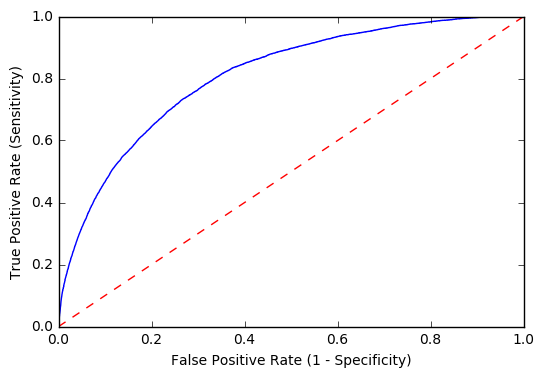

In [47]:
forest_model2, rand_col_keep2, rand_col_reg2 = model_info(ensemble.RandomForestClassifier(n_estimators=5000, max_depth=5, n_jobs=-1), labeled_dummies.drop(col_reg[0:20], axis=1), y)

('F1: ', 0.27033333333333337)
('AUC: ', 0.57938465232124725)


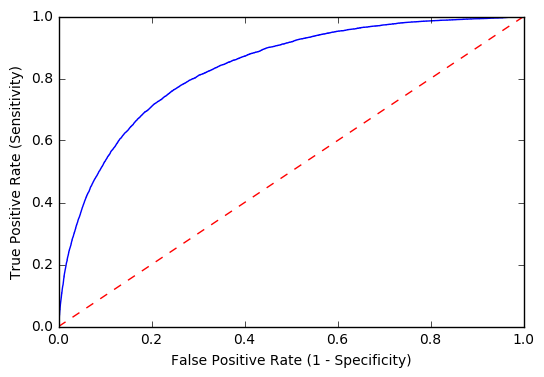

In [91]:
log_reg_01, col_keep_01, col_reg_01 = model_info(LogisticRegression(penalty='l1', C=.01), labeled_dummies, y)

0.824678666593
('Max F1: ', (0.17999999999999999, 0.43911484732352579))
('Max Recall: ', (0.02, 1.0))


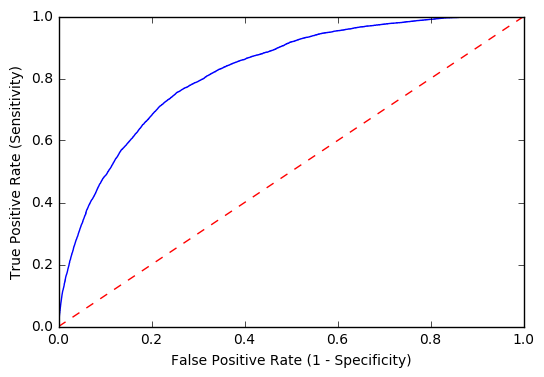

In [49]:
forest_model3, rand_col_keep3, rand_col_reg3 = model_info(ensemble.RandomForestClassifier(n_estimators=5000, max_depth=5, n_jobs=-1), labeled_dummies.drop(col_reg_01, axis=1), y)

0.843776239588
('Max F1: ', (0.20999999999999999, 0.47596758115546306))
('Max Recall: ', (0.0, 1.0))


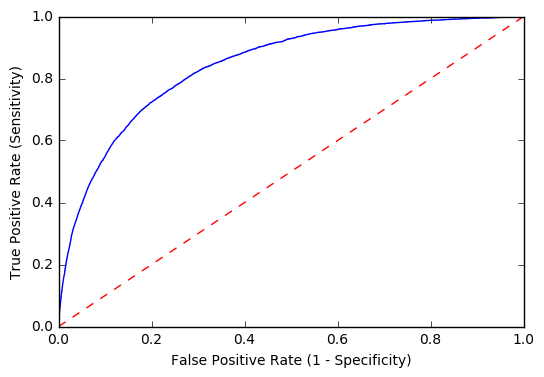

In [52]:
log_reg_05, col_keep_05, col_reg_05 = model_info(LogisticRegression(penalty='l1', C=.05), labeled_dummies, y)

('F1: ', 0.25676775900671689)
('AUC: ', 0.57433668077239142)


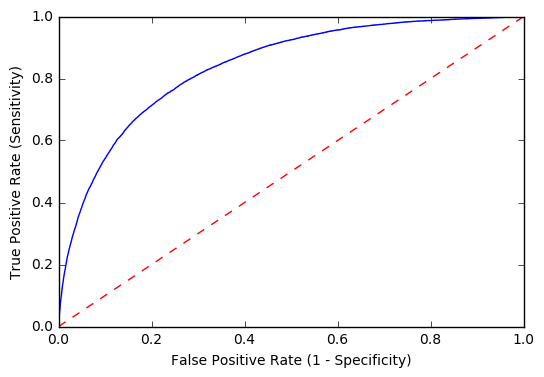

In [17]:
log_reg_001, col_keep_001, col_reg_001 = model_info(LogisticRegression(penalty='l1', C=.01), labeled_dummies, y)

In [59]:
len(col_reg_1)

206

In [63]:
labeled_norm = labeled_dummies_norm.drop(col_reg_1, axis=1)

In [12]:
pca = decomposition.PCA(n_components=20)
pca.fit(labeled_dummies_norm)
print(pca.explained_variance_ratio_)
labeled_trans = pca.transform(labeled_dummies_norm)

[ 0.16385762  0.13875703  0.06368046  0.05303739  0.05118859  0.04197725
  0.03430577  0.02824274  0.02682153  0.02140793  0.01642909  0.01430006
  0.01158525  0.01076886  0.01043439  0.01001309  0.0098019   0.00953443
  0.0086668   0.00839354]


In [92]:
sgd_model, col_keep_sgd, col_reg_sgd = model_info(SGDClassifier(n_iter=500, penalty='l2', n_jobs=-1), labeled_dummies.drop(col_reg_01, axis=1), y) 

('F1: ', 0.0)
('AUC: ', 0.5)


In [ ]:
knn_model, col_keep_knn, col_reg_knn = model_info(KNeighborsClassifier(n_neighbors=10, n_jobs=-1, algorithm='kd_tree'), labeled_dummies.drop(col_reg_001, axis=1), y)

In [ ]:
log_model = model_info2()

In [54]:
#scores = cross_val_score(log_reg_1, labeled_dummies, y, cv=5, scoring='f1')

In [49]:
# logistic = linear_model.LogisticRegression()

# pca = decomposition.PCA()
# pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [50]:
# pca.fit(labeled_dummies)

# plt.figure(1, figsize=(4, 3))
# plt.clf()
# plt.axes([.2, .2, .7, .7])
# plt.plot(pca.explained_variance_, linewidth=2)
# plt.axis('tight')
# plt.xlabel('n_components')
# plt.ylabel('explained_variance_')
# plt.axis([0,10,0,1000]);

In [41]:
# scores = cross_validation.cross_val_score(model, X_train, y_train, n_jobs=1, cv = 10)
# print("Score: " + str(np.mean(scores)))

In [52]:
#pca = decomposition.PCA(n_components=20)
#pca.fit(labeled_norm)
#print(pca.explained_variance_ratio_)
#labeled_trans = pca.transform(labeled_norm)

In [275]:
zip(threshvec, f1vec)

[(0.029999999999999999, 0.20612824473120425),
 (0.040000000000000001, 0.20794965619848002),
 (0.050000000000000003, 0.21420952893785791),
 (0.059999999999999998, 0.22986814681066864),
 (0.070000000000000007, 0.24935798980156049),
 (0.080000000000000002, 0.28590019809997547),
 (0.089999999999999997, 0.32661680598328202),
 (0.10000000000000001, 0.35187053633252219),
 (0.11, 0.36640406498857786),
 (0.12, 0.37909630305796438),
 (0.13, 0.39537486012681827),
 (0.14000000000000001, 0.40746899277633913),
 (0.14999999999999999, 0.42180913970342965),
 (0.16, 0.43255908720456404),
 (0.17000000000000001, 0.43352644646753441),
 (0.17999999999999999, 0.43111574556830035),
 (0.19, 0.42666171555885629),
 (0.20000000000000001, 0.4155156298681067),
 (0.20999999999999999, 0.3940554444126893),
 (0.22, 0.36444775009297137),
 (0.23000000000000001, 0.33554994015161588),
 (0.23999999999999999, 0.3028194020311058),
 (0.25, 0.27118897873614856),
 (0.26000000000000001, 0.24402025710946629),
 (0.27000000000000002

In [276]:
preds = new_model.predict_proba(X_test2)
roc_auc_score(y_test2,preds[:,1])

0.82413182102099913

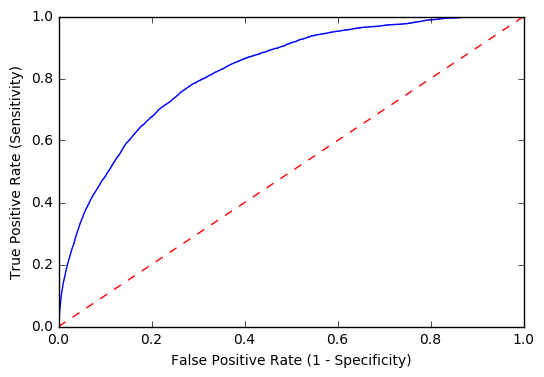

In [277]:
fpr, tpr, thresholds = roc_curve(y_test2,preds[:,1])
plt.plot(fpr, tpr);
plt.plot(fpr,fpr, 'r--');
plt.xlabel("False Positive Rate (1 - Specificity)");
plt.ylabel("True Positive Rate (Sensitivity)");

In [283]:
zipped = zip(X_train2.columns,new_model.feature_importances_)
zipped.sort(key = lambda t: t[1], reverse=True)

In [284]:
zipped

[('cit_5', 0.14992114150827759),
 ('hincp', 0.10684274610521861),
 ('agep', 0.10667433962578479),
 ('msp_6', 0.076033768354809197),
 ('indp_-1', 0.041332855847613086),
 ('mil_5', 0.040732068285527216),
 ('cow_-1', 0.03925845389750815),
 ('mar_1', 0.030931862583655909),
 ('type_2', 0.028314473011544602),
 ('indp_770', 0.023407698695217236),
 ('fs_1', 0.023354477643108593),
 ('fs_2', 0.022538031326808684),
 ('bld_2', 0.022134966958860157),
 ('rac1p_8', 0.021980292320540322),
 ('indp_8680', 0.021121895132455989),
 ('mil_-1', 0.019118205572093327),
 ('sch_1', 0.016523047628301219),
 ('np', 0.016019344279539875),
 ('wkhp', 0.015284906819660313),
 ('fes_1', 0.014349737500177692),
 ('rac1p_1', 0.011194081977475141),
 ('veh', 0.0098666296444623307),
 ('sex_2', 0.0078538118032813759),
 ('sex_1', 0.00746504270627111),
 ('dis_1', 0.007374276840202712),
 ('dis_2', 0.007328867797769068),
 ('cow_6', 0.0068955026426963783),
 ('jwtr_1', 0.0066865813005265963),
 ('sch_2', 0.0065472584977276059),
 ('hht

In [291]:
pca2 = decomposition.PCA(n_components=3)
pca2.fit(labeled_dummies2)
print(pca2.explained_variance_ratio_)
labeled_dummies2_trans = pca2.transform(labeled_dummies2)
Xtrans2_train, Xtrans2_test, y_train, y_test = train_test_split(labeled_dummies2_trans, y, test_size=0.33)

[  9.73326158e-01   2.66165486e-02   5.71363718e-05]


In [292]:
new_model2 = ensemble.RandomForestClassifier(n_estimators=5000, max_depth=5, n_jobs=-1)
new_model2.fit(Xtrans2_train, y_train)
digit_prec=2
truthvec = y_test
scorevec = new_model2.predict_proba(Xtrans2_test)[:,1]
threshvec = np.unique(np.round(scorevec,digit_prec))
numthresh = len(threshvec)
tpvec = np.zeros(numthresh)
fpvec = np.zeros(numthresh)
fnvec = np.zeros(numthresh)
for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
recallvec = tpvec/(tpvec + fnvec)
precisionvec = tpvec/(tpvec + fpvec)
f1vec = 2*precisionvec*recallvec/(precisionvec + recallvec)

In [293]:
new_preds = new_model2.predict_proba(Xtrans2_test)
roc_auc_score(y_test,new_preds[:,1])

0.68551524378578865

In [296]:
model_lr4 = LogisticRegression()
model_lr4.fit(Xtrans2_train, y_train)
pred_vals_lr4 = model_lr4.predict_proba(Xtrans2_test)

In [297]:
roc_auc_score(y_test, pred_vals_lr4[:,1])

0.6711211900853461

In [299]:
digit_prec=2
truthvec = y_test
scorevec = pred_vals_lr4[:,1]
threshvec = np.unique(np.round(scorevec,digit_prec))
numthresh = len(threshvec)
tpvec = np.zeros(numthresh)
fpvec = np.zeros(numthresh)
fnvec = np.zeros(numthresh)
for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
recallvec = tpvec/(tpvec + fnvec)
precisionvec = tpvec/(tpvec + fpvec)
f1vec = 2*precisionvec*recallvec/(precisionvec + recallvec)

In [301]:
x=zip(threshvec, f1vec)

In [310]:
sorted(x,key=lambda m: m[1], reverse=True)[0]

(0.14999999999999999, 0.27927539846282901)

0.819484678537
('Max F1: ', (0.17000000000000001, 0.42897974400397659))
('Max Recall: ', (0.029999999999999999, 1.0))
[('cit_5', 0.14443420913158561), ('hincp', 0.11227434868906055), ('agep', 0.10687965882607091), ('msp_6', 0.077098141741208298), ('mil_5', 0.044849203614171905), ('cow_-1', 0.040104886416016144), ('indp_-1', 0.039980375665383532), ('mar_1', 0.029195101325791704), ('type_2', 0.029116117193839615), ('indp_770', 0.025620369406685269), ('fs_1', 0.021754902198606329), ('rac1p_8', 0.021458013138732905), ('fs_2', 0.020926219669025043), ('indp_8680', 0.02081122432374621), ('bld_2', 0.020549876902041991), ('mil_-1', 0.018303640873936711), ('wkhp', 0.016354692945068333), ('sch_1', 0.016159508792562144), ('np', 0.01534110066321131), ('fes_1', 0.015235230080125254), ('rac1p_1', 0.011047905208713923), ('veh', 0.0092969920349639246), ('dis_2', 0.008008245767298373), ('sex_1', 0.0079628238354884692), ('dis_1', 0.0078987235766081586), ('sex_2', 0.0077806189223863865), ('jwtr_1', 0.0070

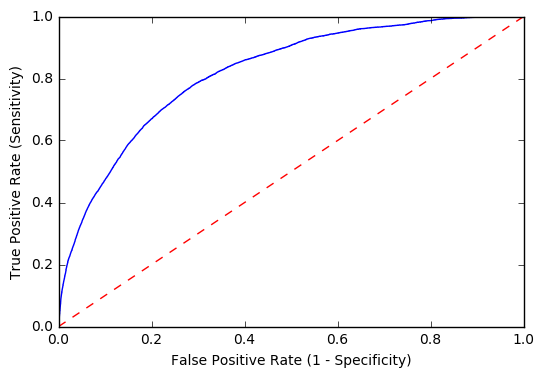

In [314]:
best_model = model_info(ensemble.RandomForestClassifier(n_estimators=5000, max_depth=5, n_jobs=-1), labeled_dummies2, y)

0.697625160684
('Max F1: ', (0.14999999999999999, 0.31463888589010042))
('Max Recall: ', (0.0, 1.0))
[(0.0048965302529110893, 'mil_5'), (0.0034556192879452241, 'cit_5'), (0.0021674832541619051, 'msp_6'), (0.00047354601998944243, 'type_2'), (0.00010942278186950562, 'mar_1'), (-1.8662923777202813e-05, 'hincp'), (-0.010407903616028167, 'indp_-1'), (-0.010407903616028167, 'cow_-1'), (-0.023046788968372884, 'agep')]


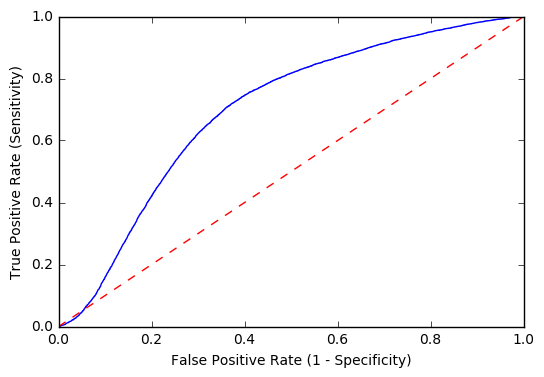

In [347]:
frames = [labeled_dummies2['cit_5'], labeled_dummies2['hincp'], labeled_dummies2['agep'], labeled_dummies2['msp_6'], labeled_dummies2['mil_5'],
         labeled_dummies2['cow_-1'], labeled_dummies2['indp_-1'], labeled_dummies2['mar_1'], labeled_dummies2['type_2']]
df_frames = pd.concat(frames, axis=1)
model = model_info(LogisticRegression(), df_frames, y)